In [45]:
import glob
import os
import csv
import numpy as np
from scipy.signal import medfilt
from scipy.signal import wiener
from scipy.signal import savgol_filter

genders = ['male', 'female']
labels = ['Happy', 'Surprise', 'Disgust', 'Angry', 'Fear', 'Sad', 'Neutral'] # 0-6, 7 classes

def preprocess_data(dataPath, train):
    if train:
        path = os.path.join(dataPath, 'train')
        output_dir = os.path.join(dataPath, 'train.csv')
    else:
        path = os.path.join(dataPath, 'val')
        output_dir = os.path.join(dataPath, 'val.csv')
    folders = glob.glob(os.path.join(path, '*'))
    folders.sort()

    with open(output_dir, 'a+') as csv_output_file:
        fieldnames = ['User', 'Person_min', 'Max', 'Min', 'Mean', 'Var', 'Mean Abs Diff', 'Mean Abs Second Diff', 'Emotion', 'Gender', 'Age'] # The features extracted
        writer = csv.DictWriter(csv_output_file, fieldnames=fieldnames)
        writer.writeheader()

        for dir in folders:
            with open(os.path.join(dir, 'EDA.csv')) as csv_file:
                csv_reader = csv.reader(csv_file)
                line_count = 0
                data = [] # all data for one person
                time_stamp = [] # time stamp for each item

                for row in csv_reader:
                    if line_count == 0:
                        start_time = float(row[0])
                    elif line_count == 1:
                        freq = float(row[0])
                    elif line_count>2 :
                        data.append(float(row[0]))
                        time_stamp.append(start_time + float((line_count-2)/freq))
                    line_count += 1

                #person_Max = max(data) # Use with normalization filter
                #person_Min = min(data)
                data = (data - np.average(data)) / (np.std(data)) # standartization filter
                #data = (np.array(data) - float(person_Min)) / (float(person_Max) - float(person_Min)) # normalised data for each person
                #data = medfilt(data, 11) # median filter; Use with normalization
                #data = wiener(data)
                #data = savgol_filter(data, 11, 5)
                person_Max = max(data)
                person_Min = min(data)
                
            
                log = open(os.path.join(dir, 'log.txt'), 'r')
                log_count = 0
                for line in log:
                    if log_count == 0:
                        user = line.split(';')[0].split(':')[-1]
                        age = line.split(';')[1].split(':')[-1]
                        gender = line.split(';')[2].split(':')[-1]
                        gender = genders.index(gender.lower())
                        log_count += 1
                    elif log_count == 1:
                        log_count += 1
                    else:
                        st = float(line.split(';')[1]) # start time of each video
                        et = float(line.split(';')[3]) # end time of each video
                        video_name = line.split(';')[2]
                        if "_" in video_name:
                            emotion_label = line.split(';')[2].split('.')[0][:-10] # emotion label of each video
                        else:
                            emotion_label = line.split(';')[2].split('.')[0][:-9]  # emotion label of each video
                        emotion_label = labels.index(emotion_label)

                        index = np.where(np.logical_and((np.array(time_stamp) >= st), (np.array(time_stamp) <= et)))
                        data_list = data[index[0]]
                        if len(data_list)== 0:
                            break
                        diff_list = [data_list[k+1]-data_list[k] for k in range(len(data_list)-1)]
                        abs_diff_list = abs(np.array(diff_list))
                        second_diff_list = [diff_list[k + 1] - diff_list[k] for k in range(len(diff_list) - 1)]
                        abs_second_diff_list = abs(np.array(second_diff_list))
                        writer.writerow({'User': user, 'Person_min': person_Min,  'Max': max(data_list), 'Min': min(data_list), 'Mean': np.mean(data_list), 'Var': np.var(data_list), 'Mean Abs Diff': np.mean(abs_diff_list), 'Mean Abs Second Diff': np.mean(abs_second_diff_list),'Emotion': emotion_label, 'Gender': gender, 'Age': age})
                log.close()
        csv_file.close()
    csv_output_file.close()

In [46]:
# Preprocessing and reading data 
import pandas as pd
from sklearn.utils import shuffle


os.remove('train.csv')
preprocess_data('', train=1)
os.remove('val.csv')
preprocess_data('', train=0)


Data_train = pd.read_csv("train.csv", sep = ",")
Data_train = shuffle(Data_train)
#Data_train[Data_train.User == "Person_25"].head(10)
#Data_train.head(20)

Data_val = pd.read_csv("val.csv")
Data_val = shuffle(Data_val)
#Data_val[Data_val.User == "Person_25"].head(10)

# Vizualisation

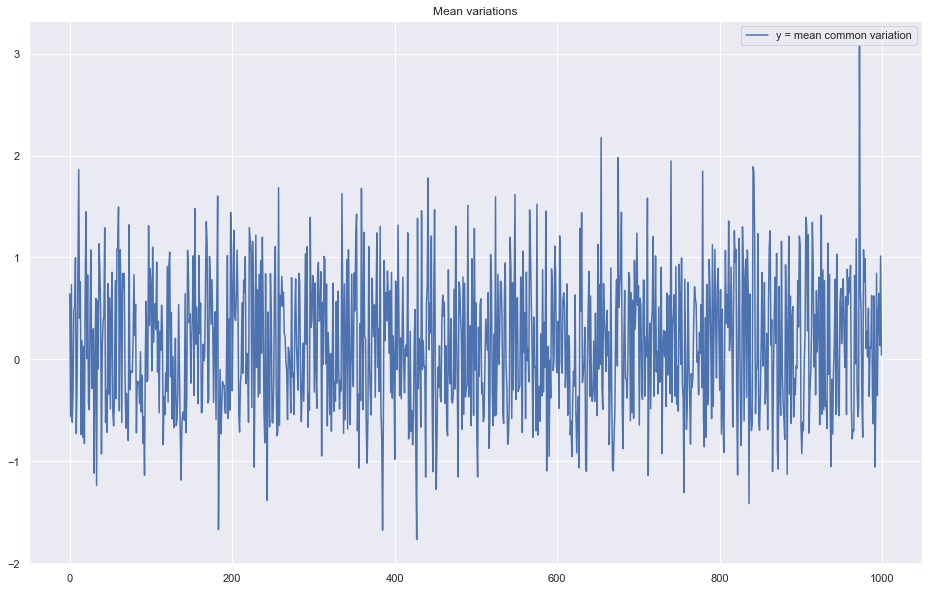

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


plt.figure(figsize=(16, 10))
plt.plot(np.arange(0, 1000, 1), Data_train.Mean.iloc[:1000], scaley = 100)
plt.title("Mean variations")
plt.legend(["y = mean common variation"])

plt.show()

<AxesSubplot:xlabel='Mean Abs Diff'>

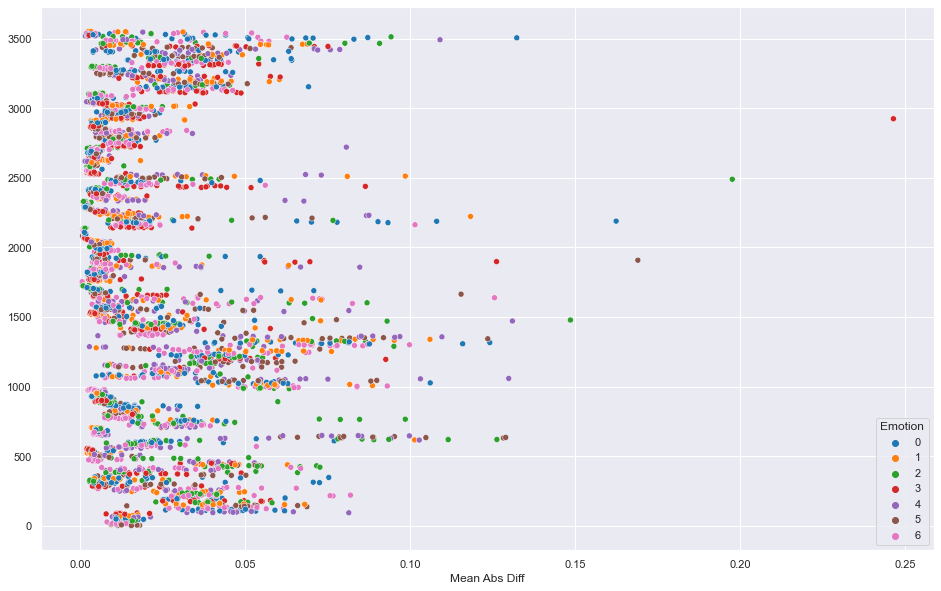

In [48]:
#Max	Min	Mean	Var	Mean Abs Diff	Mean Abs Second Diff	Emotion

sns.set(rc = {'figure.figsize':(16, 10)})
sns.set_theme(style="darkgrid")
sns.scatterplot(data = Data_train, x = "Mean Abs Diff", y = Data_train.index, hue = "Emotion", palette = "tab10", x_bins= 150)

In [49]:
Data_train.isna().sum()

User                    0
Person_min              0
Max                     0
Min                     0
Mean                    0
Var                     0
Mean Abs Diff           0
Mean Abs Second Diff    0
Emotion                 0
Gender                  0
Age                     0
dtype: int64

,Emotion
0,699
6,676
3,475
5,472
2,436
4,434
1,362


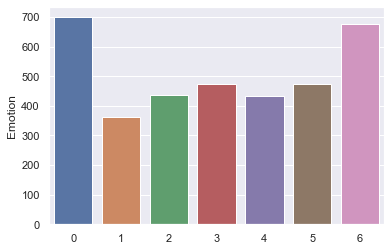

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

distribution = pd.DataFrame(Data_train.Emotion.value_counts())
sns.barplot(y = distribution.Emotion, x = distribution.index)
distribution

In [51]:
#Data_train[Data_train.User == "Person_25"].head(15)

In [52]:
#Data_val[Data_val.User == "Person_25"].head(15)

####  Data is distributed normally. No NaN values. Sad and happy emotions have more samples than others -> might have to equalize value counts

In [53]:
# Merging val and train data
print(Data_train.shape, Data_val.shape)
Data_train = pd.merge(Data_train, Data_val, how = 'outer')
Data_train.shape

(3554, 11) (1737, 11)


(5291, 11)

## Model architectures

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.regularizers import L1, L2, L1L2

def initModelBasic(shape, outputUnits) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    model = Sequential()
    
    model.add(tf.keras.Input(shape = (shape)))
    
    model.add(Dense(16, activation = 'linear'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(16, activation = 'linear'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(outputUnits, activation = 'softmax'))
    print(model.summary())
    return model

def initModelValence(shape, outputUnits) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    model = Sequential()
    
    model.add(tf.keras.Input(shape = shape))
    
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    #model.add(ReLU())
    
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    #model.add(ReLU())
    
    model.add(Dense(outputUnits, activation = 'sigmoid'))
    print(model.summary())
    return model

    

### Basic model
#### input -> predict emotion

In [57]:
from sklearn.model_selection import train_test_split


np.random.seed = 123

y = Data_train.Emotion
X = pd.DataFrame(Data_train.drop(['Emotion','User'], axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)



model = initModelBasic(X.shape[1], 7)
model.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy', # sparse because using integer labels for emotions (not OHE)
    metrics=[ 'sparse_categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model.fit(
    X_train,
    y_train,
    #validation_split = 0.3,
    #validation_data = (X_val, y_val),
    validation_data = (X_test, y_test),
    epochs=800,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy',
            patience=200,
            restore_best_weights=True
        )
    ]
)

#Result on test data
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))

#Result on val data
model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 16)                0

ValueError: in user code:

    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\training.py", line 864, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\metrics.py", line 1533, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\utils\metrics_utils.py", line 619, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 7) and (None, 1) are incompatible


In [ ]:
# Visualize accuracy graph
from keras.models import load_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))

model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))




# Plot the accuracy curve for training
plt.figure(figsize=(16, 10))
plt.plot(history.history['val_sparse_categorical_accuracy'], color='r', label="Accuracy")


plt.title("Validation accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [13]:
import graphviz
import pydot
import pydotplus
%matplotlib inline

img_file = "BasicModel" + '.png'
tf.keras.utils.plot_model(model,
to_file=img_file,
show_shapes=True,
show_layer_names=True)



You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Two-step Model
#### Input -> predict valence -> concat -> input -> predict emotion

### Valence prediction

In [15]:
#Positive: surprise, happy, neutral
#Negative: else
# labels = ['Happy', 'Surprise', 'Disgust', 'Angry', 'Fear', 'Sad', 'Neutral'] # 0-6, 7 classes

def getValence(row) -> int:
        if row['Emotion'] == 0 or row['Emotion'] == 1 or row['Emotion'] == 6:
            return 1
        else:
            return 0

Data_train['Valence'] = Data_train.apply(lambda row: getValence(row), axis = 1)

### Modeling

In [17]:
from sklearn.model_selection import train_test_split

#Get target variables: emotion and valence
z = Data_train.Valence
y = Data_train.Emotion
X = pd.DataFrame(Data_train.drop(['Emotion','User', 'Valence'], axis = 1))

#find valence
tf.random.set_seed(123)

modelValence = initModelValence(X.shape[1], 2)
modelValence.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy', 
    metrics=[ 'sparse_categorical_accuracy']
)

historyValence = modelValence.fit(
    X,
    z,
    validation_split = 0.3,
    #validation_data = (X_val, y_val),
    #validation_data = (X_test, y_test),
    epochs=600,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy',
            patience=75,
            restore_best_weights=True
        )
    ]
)

model_acc = modelValence.evaluate(X, z, verbose=0)[1]
print("Accuracy of the valence model: {:.3f}%".format(model_acc * 100))

Data_valence = modelValence.predict(X)
Data_valence = [(np.argmax(pre)) for pre in Data_valence]
#print(Data_valence, z)

X = pd.concat([X, pd.DataFrame(Data_valence, columns = ['Valence'])], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)



model = initModelBasic(X.shape[1], 7)
model.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy', # sparse because using integer labels for emotions (not OHE)
    metrics=[ 'sparse_categorical_accuracy']
)

history = model.fit(
    X_train,
    y_train,
    #validation_split = 0.3,
    #validation_data = (X_val, y_val),
    validation_data = (X_test, y_test),
    epochs=600,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy',
            patience=75,
            restore_best_weights=True
        )
    ]
)

#Result on test data
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))

#Result on val data
model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,170
Trainable params: 2,978
Non-trainabl

116/116 [==============================] - 0s 2ms/step - loss: 0.6569 - sparse_categorical_accuracy: 0.6090 - val_loss: 0.7418 - val_sparse_categorical_accuracy: 0.5139
Epoch 40/600
116/116 [==============================] - 0s 2ms/step - loss: 0.6589 - sparse_categorical_accuracy: 0.6022 - val_loss: 0.7191 - val_sparse_categorical_accuracy: 0.5239
Epoch 41/600
116/116 [==============================] - 0s 2ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.6052 - val_loss: 0.7221 - val_sparse_categorical_accuracy: 0.5126
Epoch 42/600
116/116 [==============================] - 0s 2ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.6125 - val_loss: 0.7344 - val_sparse_categorical_accuracy: 0.4931
Epoch 43/600
116/116 [==============================] - 0s 2ms/step - loss: 0.6585 - sparse_categorical_accuracy: 0.5976 - val_loss: 0.7178 - val_sparse_categorical_accuracy: 0.5384
Epoch 44/600
116/116 [==============================] - 0s 2ms/step - loss: 0.6582 - sparse_categorical

116/116 [==============================] - 0s 3ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6335 - val_loss: 0.7517 - val_sparse_categorical_accuracy: 0.5189
Accuracy of the valence model: 58.892%
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                176       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Batc  (None, 16)      

Epoch 37/600
105/105 [==============================] - 0s 3ms/step - loss: 1.8460 - sparse_categorical_accuracy: 0.2437 - val_loss: 1.8601 - val_sparse_categorical_accuracy: 0.2311
Epoch 38/600
105/105 [==============================] - 0s 2ms/step - loss: 1.8474 - sparse_categorical_accuracy: 0.2407 - val_loss: 1.8700 - val_sparse_categorical_accuracy: 0.2110
Epoch 39/600
105/105 [==============================] - 0s 2ms/step - loss: 1.8477 - sparse_categorical_accuracy: 0.2362 - val_loss: 1.8544 - val_sparse_categorical_accuracy: 0.2475
Epoch 40/600
105/105 [==============================] - 0s 3ms/step - loss: 1.8481 - sparse_categorical_accuracy: 0.2473 - val_loss: 1.8597 - val_sparse_categorical_accuracy: 0.2368
Epoch 41/600
105/105 [==============================] - 0s 3ms/step - loss: 1.8450 - sparse_categorical_accuracy: 0.2407 - val_loss: 1.8422 - val_sparse_categorical_accuracy: 0.2506
Epoch 42/600
105/105 [==============================] - 0s 2ms/step - loss: 1.8443 - spars

105/105 [==============================] - 0s 3ms/step - loss: 1.8109 - sparse_categorical_accuracy: 0.2653 - val_loss: 1.8436 - val_sparse_categorical_accuracy: 0.2399
Epoch 83/600
105/105 [==============================] - 0s 2ms/step - loss: 1.8133 - sparse_categorical_accuracy: 0.2599 - val_loss: 1.8264 - val_sparse_categorical_accuracy: 0.2557
Epoch 84/600
105/105 [==============================] - 0s 2ms/step - loss: 1.8076 - sparse_categorical_accuracy: 0.2647 - val_loss: 1.8128 - val_sparse_categorical_accuracy: 0.2557
Epoch 85/600
105/105 [==============================] - 0s 2ms/step - loss: 1.8165 - sparse_categorical_accuracy: 0.2635 - val_loss: 1.8205 - val_sparse_categorical_accuracy: 0.2506
Epoch 86/600
105/105 [==============================] - 0s 3ms/step - loss: 1.8112 - sparse_categorical_accuracy: 0.2587 - val_loss: 1.8229 - val_sparse_categorical_accuracy: 0.2557
Epoch 87/600
105/105 [==============================] - 0s 2ms/step - loss: 1.8040 - sparse_categorical

Epoch 127/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7856 - sparse_categorical_accuracy: 0.2821 - val_loss: 1.7943 - val_sparse_categorical_accuracy: 0.2859
Epoch 128/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7919 - sparse_categorical_accuracy: 0.2767 - val_loss: 1.8002 - val_sparse_categorical_accuracy: 0.2821
Epoch 129/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7910 - sparse_categorical_accuracy: 0.2809 - val_loss: 1.8242 - val_sparse_categorical_accuracy: 0.2443
Epoch 130/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7900 - sparse_categorical_accuracy: 0.2791 - val_loss: 1.8563 - val_sparse_categorical_accuracy: 0.2494
Epoch 131/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7949 - sparse_categorical_accuracy: 0.2689 - val_loss: 1.8198 - val_sparse_categorical_accuracy: 0.2569
Epoch 132/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7879 -

Epoch 172/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7783 - sparse_categorical_accuracy: 0.2788 - val_loss: 1.7836 - val_sparse_categorical_accuracy: 0.2947
Epoch 173/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7785 - sparse_categorical_accuracy: 0.2911 - val_loss: 1.8441 - val_sparse_categorical_accuracy: 0.2506
Epoch 174/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7635 - sparse_categorical_accuracy: 0.2956 - val_loss: 1.8004 - val_sparse_categorical_accuracy: 0.2733
Epoch 175/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7694 - sparse_categorical_accuracy: 0.2941 - val_loss: 1.7805 - val_sparse_categorical_accuracy: 0.2840
Epoch 176/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7699 - sparse_categorical_accuracy: 0.2953 - val_loss: 1.8002 - val_sparse_categorical_accuracy: 0.2582
Epoch 177/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7786 -

Epoch 217/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7737 - sparse_categorical_accuracy: 0.2887 - val_loss: 1.7864 - val_sparse_categorical_accuracy: 0.2941
Epoch 218/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7601 - sparse_categorical_accuracy: 0.2953 - val_loss: 1.7637 - val_sparse_categorical_accuracy: 0.3054
Epoch 219/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7696 - sparse_categorical_accuracy: 0.2935 - val_loss: 1.7969 - val_sparse_categorical_accuracy: 0.3060
Epoch 220/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7629 - sparse_categorical_accuracy: 0.2854 - val_loss: 1.7713 - val_sparse_categorical_accuracy: 0.2853
Epoch 221/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7683 - sparse_categorical_accuracy: 0.2920 - val_loss: 1.8272 - val_sparse_categorical_accuracy: 0.2626
Epoch 222/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7598 -

Epoch 262/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7552 - sparse_categorical_accuracy: 0.2986 - val_loss: 1.8000 - val_sparse_categorical_accuracy: 0.2865
Epoch 263/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7572 - sparse_categorical_accuracy: 0.2872 - val_loss: 1.7794 - val_sparse_categorical_accuracy: 0.2922
Epoch 264/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7594 - sparse_categorical_accuracy: 0.2914 - val_loss: 1.7699 - val_sparse_categorical_accuracy: 0.3111
Epoch 265/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7538 - sparse_categorical_accuracy: 0.2944 - val_loss: 1.7569 - val_sparse_categorical_accuracy: 0.3023
Epoch 266/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7633 - sparse_categorical_accuracy: 0.2854 - val_loss: 1.7988 - val_sparse_categorical_accuracy: 0.2651
Epoch 267/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7545 -

Epoch 307/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7599 - sparse_categorical_accuracy: 0.2977 - val_loss: 1.7499 - val_sparse_categorical_accuracy: 0.3048
Epoch 308/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7475 - sparse_categorical_accuracy: 0.2911 - val_loss: 1.7980 - val_sparse_categorical_accuracy: 0.2802
Epoch 309/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7465 - sparse_categorical_accuracy: 0.2881 - val_loss: 1.7599 - val_sparse_categorical_accuracy: 0.3161
Epoch 310/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7600 - sparse_categorical_accuracy: 0.2869 - val_loss: 1.7619 - val_sparse_categorical_accuracy: 0.3117
Epoch 311/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7568 - sparse_categorical_accuracy: 0.2920 - val_loss: 1.7632 - val_sparse_categorical_accuracy: 0.3218
Epoch 312/600
105/105 [==============================] - 0s 2ms/step - loss: 1.7589 -

Accuracy of the model on test set: 33.249%
Accuracy of the model on validation set: 35.849%


In [43]:
# Visualize accuracy graph
from keras.models import load_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))

model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))

precision = tf.keras.metrics.Precision()
precision.update_state(y_val, model.predict(X_val))
precision_metric = precision.result().numpy()
print("Precision of the model on validation set: {:.3f}%".format(precision_metric))

# Plot the accuracy curve for training
plt.figure(figsize=(16, 10))
plt.plot(history.history['val_sparse_categorical_accuracy'], color='r', label="Accuracy")


plt.title("Validation accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

ValueError: in user code:

    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\yadim\miniconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 10), found shape=(None, 9)


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from lightgbm.sklearn import LGBMModel
y = Data_train.Emotion
z = Data_train.Valence
X = pd.DataFrame(Data_train.drop(['Emotion','User', 'Valence'], axis = 1))

models = [ KNeighborsClassifier(n_neighbors= 7), DecisionTreeClassifier(), RandomForestClassifier()]
model_names = ['K-Neighbors Classifier', 'Decision Tree Classifier', 'Random Forest Classifier']
scores = np.zeros([len(models), 1])


X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.3, random_state = 123)

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, z_train)

z_pred = clf.predict(X)
#X = pd.concat([X, pd.DataFrame(data = z_pred, columns = ['Valence'])], axis = 1)
#print("Valence acc score: ", clf.score(X_test, z_test))

for i, m in enumerate(models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)
    clf =  m.fit(X_train, y_train)
    scores[i] = clf.score(X_val, y_val)
    
scores = pd.DataFrame(scores, columns=['score'], index=model_names)
scores


# K-Neighbors Classifier	0.584383
# Decision Tree Classifier	0.493703
# Random Forest Classifier	0.568010

,score
K-Neighbors Classifier,0.611860
Decision Tree Classifier,0.471698
Random Forest Classifier,0.571429
